In [86]:
import sys
print(sys.version)
print(sys.path)

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]
['D:\\michele\\jennifer', 'D:\\michele\\miniconda3\\envs\\prediction\\python37.zip', 'D:\\michele\\miniconda3\\envs\\prediction\\DLLs', 'D:\\michele\\miniconda3\\envs\\prediction\\lib', 'D:\\michele\\miniconda3\\envs\\prediction', '', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages\\xgboost-0.83.dev0-py3.7.egg', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mtinti\\.ipython']


In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
from scipy import stats
from scipy.spatial import distance
import re
from sklearn import cluster
from sklearn.metrics import  silhouette_score
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multitest as smm
from sklearn.decomposition import PCA
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import ttest_ind
#from plotly.widgets import GraphWidget
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [88]:
df = pd.read_table('indata/proteinGroups1.txt')
df.head()
print(df.shape)
df = df[df['Only identified by site']!='+']
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
print(df.shape)

(8466, 183)
(8197, 183)


In [89]:
hippo_cols = ['Reporter intensity corrected {} Hippo'.format(n) for n in range(0,10)]
hippo_df=df[hippo_cols]
hippo_df.head(10)

,Reporter intensity corrected 0 Hippo,Reporter intensity corrected 1 Hippo,Reporter intensity corrected 2 Hippo,Reporter intensity corrected 3 Hippo,Reporter intensity corrected 4 Hippo,Reporter intensity corrected 5 Hippo,Reporter intensity corrected 6 Hippo,Reporter intensity corrected 7 Hippo,Reporter intensity corrected 8 Hippo,Reporter intensity corrected 9 Hippo
0,227970.0,240490.0,206900.0,196000.0,219410.0,177290.0,147270.0,215440.0,191040.0,82206.0
1,36097.0,36280.0,35608.0,44122.0,37243.0,33822.0,34705.0,33281.0,32376.0,45579.0
2,18755.0,17425.0,20089.0,22460.0,21564.0,18070.0,17781.0,20207.0,19243.0,17319.0
3,206180.0,194780.0,216630.0,216160.0,226410.0,174170.0,194190.0,204090.0,191320.0,123500.0
4,1786200.0,1576600.0,1713600.0,2023000.0,1824100.0,1512500.0,1698900.0,1569300.0,1619100.0,885390.0
5,11234.0,13958.0,12630.0,13144.0,14907.0,10397.0,11195.0,12106.0,12493.0,18884.0
6,710890.0,745020.0,700080.0,680230.0,738720.0,589450.0,524230.0,678920.0,598310.0,432270.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,227360.0,235420.0,223980.0,203510.0,224790.0,186780.0,158890.0,216790.0,194570.0,69818.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
hippo_df = hippo_df.replace(0, np.nan)
hippo_df.dropna(how='all', axis=0,inplace=True)
#hippo_df.head(10)

In [91]:
hippo_df.columns = ['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3','null']
del hippo_df['null']
#hippo_df.head(10)

In [92]:
#np.log2(hippo_df).describe()

In [93]:
#np.log2(hippo_df).plot(kind='box')

In [94]:
#np.log2(hippo_df).plot(kind='kde')

In [95]:
col_sum = hippo_df.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
norm_facs

ND_1    0.941160
ND_2    0.940616
ND_3    0.975003
HF_1    0.926340
HF_2    0.903498
HF_3    1.136185
KO_1    1.176951
KO_2    1.001444
KO_3    1.070624
dtype: float64

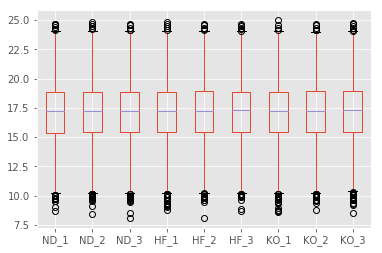

In [96]:
hippo_df = hippo_df.multiply(norm_facs,axis=1)
np.log2(hippo_df).plot(kind='box')

In [97]:
#msn.bar(np.log2(hippo_df))

In [98]:
def make_pca(in_df):
    cols = in_df.columns
    pca = PCA(n_components=2)
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    fig,ax=plt.subplots()
    temp_df.iloc[0:3,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='g', ax=ax,legend ='ND')
    temp_df.iloc[3:6,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='b', ax=ax, legend='HF')    
    temp_df.iloc[6:9,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='r', ax=ax, legend='KO')
    for i, txt in enumerate(cols):
        ax.annotate(txt, (temp_df['pc_1'].values[i]+0.0003,temp_df['pc_2'].values[i]))
    #ax.set_xlabel('PC1({})'.format(round(pca.explained_variance_ratio_[0],2)))
    #ax.set_ylabel('PC2({})'.format(round(pca.explained_variance_ratio_[1],2)))
    #ax.set_xlim(0.345,0.360)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]))
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    #plt.tick_params(axis='both', which='major', labelsize=16, rotation=70, horizontalalignment='right' )
    #plt.setp( axs[1].xaxis.get_majorticklabels(), )
    fig.savefig('pca.svg')
    fig.savefig('pca.png')
    fig.savefig('pca.pdf')
    plt.legend()
    plt.show()

In [99]:
#from tqdm import tqdm_notebook
#from scipy.stats import f_oneway
#pvalue_list=[]
#for n in tqdm_notebook(hippo_df.index.values):
#    try:
#        onesample_results = f_oneway( np.log1p(hippo_df)[['ND_1','ND_2','ND_3']].iloc[n], 
#                                  np.log1p(hippo_df)[['KO_1','KO_2','KO_3']].iloc[n],
#                                  np.log1p(hippo_df)[['HF_1','HF_2','HF_3']].iloc[n])
#        pvalue_list.append(onesample_results.pvalue)
#        
#    except:
#        pvalue_list.append(np.nan)
#
#pvalues=pd.Series(pvalue_list,index=hippo_df.index.values)
#pvalues.plot(kind='hist')


[0.9955353  0.00170997]


No handles with labels found to put in legend.


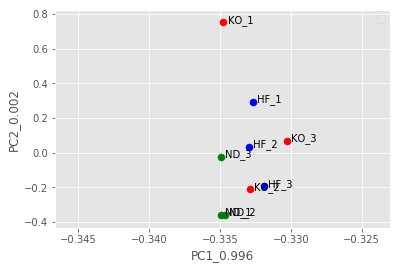

In [100]:
hippo_df=hippo_df.fillna(0)
make_pca(np.log1p(hippo_df))

In [101]:
onesample_results = ttest_ind(hippo_df[['ND_1','ND_2','ND_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['ND_KO_pvalue']=onesample_results.pvalue
hippo_df['ND_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['HF_KO_pvalue']=onesample_results.pvalue
hippo_df['HF_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['ND_1','ND_2','ND_3']].T)
#print(onesample_results)
hippo_df['HF_ND_pvalue']=onesample_results.pvalue
hippo_df['HF_ND_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]


hippo_df['log10_ND_KO_pvalue']=-np.log10(hippo_df['ND_KO_pvalue'])
hippo_df['log10_HF_KO_pvalue']=-np.log10(hippo_df['HF_KO_pvalue'])
hippo_df['log10_HF_ND_pvalue']=-np.log10(hippo_df['HF_ND_pvalue'])

#for visualization later
hippo_df['mean_ND'] = hippo_df[['ND_1','ND_2','ND_3']].median(axis=1)
hippo_df['mean_HF'] = hippo_df[['HF_1','HF_2','HF_3']].median(axis=1)
hippo_df['mean_KO'] = hippo_df[['KO_1','KO_2','KO_3']].median(axis=1)

hippo_df['log2_fc_HF_ND'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_ND'])
hippo_df['log2_fc_ND_KO'] = np.log2(hippo_df['mean_ND']/hippo_df['mean_KO'])
hippo_df['log2_fc_HF_KO'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_KO'])

hippo_df.head()

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3,ND_KO_pvalue,...,HF_ND_pvalue_corr,log10_ND_KO_pvalue,log10_HF_KO_pvalue,log10_HF_ND_pvalue,mean_ND,mean_HF,mean_KO,log2_fc_HF_ND,log2_fc_ND_KO,log2_fc_HF_KO
0,2.145563e+05,2.262088e+05,2.017281e+05,1.815626e+05,1.982366e+05,2.014343e+05,1.733295e+05,2.157510e+05,2.045320e+05,0.324814,...,1.0,0.488365,0.105435,1.022286,2.145563e+05,1.982366e+05,2.045320e+05,-0.114133,0.069030,-0.045103
1,3.397306e+04,3.412555e+04,3.471791e+04,4.087197e+04,3.364899e+04,3.842806e+04,4.084607e+04,3.332905e+04,3.466252e+04,0.437012,...,1.0,0.359507,0.164273,0.724623,3.412555e+04,3.842806e+04,3.466252e+04,0.171308,-0.022524,0.148784
2,1.765146e+04,1.639023e+04,1.958683e+04,2.080559e+04,1.948304e+04,2.053087e+04,2.092736e+04,2.023617e+04,2.060202e+04,0.046268,...,1.0,1.334715,0.282498,1.112550,1.765146e+04,2.053087e+04,2.060202e+04,0.218007,-0.222998,-0.004991
3,1.940484e+05,1.832132e+05,2.112149e+05,2.002376e+05,2.045611e+05,1.978894e+05,2.285520e+05,2.043846e+05,2.048318e+05,0.223259,...,1.0,0.651192,0.642361,0.220266,1.940484e+05,2.002376e+05,2.048318e+05,0.045296,-0.078023,-0.032726
4,1.681101e+06,1.482975e+06,1.670765e+06,1.873986e+06,1.648071e+06,1.718480e+06,1.999521e+06,1.571566e+06,1.733447e+06,0.327242,...,1.0,0.485131,0.051855,0.660499,1.670765e+06,1.718480e+06,1.733447e+06,0.040625,-0.053135,-0.012510


In [102]:
hippo_df.shape

(7405, 24)

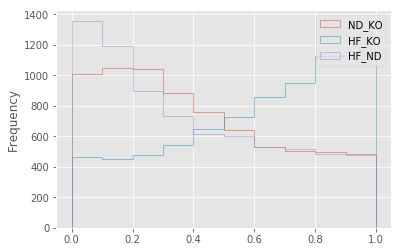

In [103]:
hippo_df['ND_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='ND_KO')
hippo_df['HF_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_KO')
hippo_df['HF_ND_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_ND')
plt.legend()
plt.show()

In [104]:
#random_df.shape

In [65]:
from adjustText import adjust_text

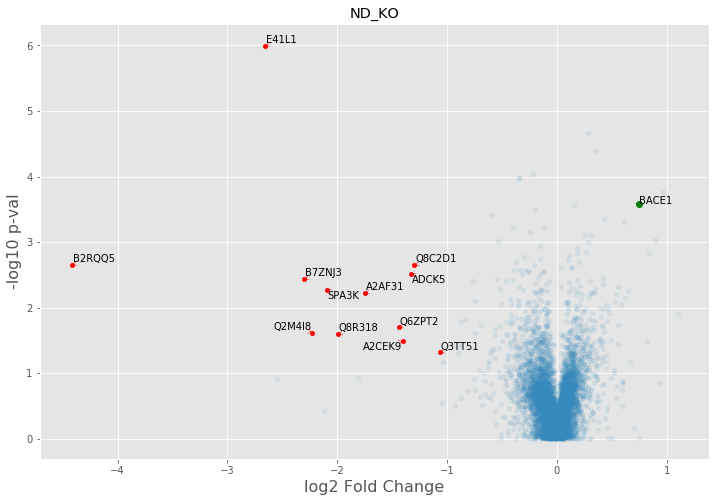

871     tr|A2AF31|A2AF31_MOUSE Thymosin beta 15b2 OS=M...
923     tr|A2CEK9|A2CEK9_MOUSE Major urinary protein 1...
1319    tr|B2RQQ5|B2RQQ5_MOUSE Microtubule-associated ...
1527    tr|B7ZNJ3|B7ZNJ3_MOUSE Caskin1 protein OS=Mus ...
3144    sp|P07759|SPA3K_MOUSE Serine protease inhibito...
3217    tr|Q3TT51|Q3TT51_MOUSE Putative uncharacterize...
4285    tr|Q2M4I8|Q2M4I8_MOUSE Ptpns1 OS=Mus musculus ...
5842    tr|Q6ZPT2|Q6ZPT2_MOUSE MKIAA1352 protein (Frag...
6021    sp|Q80V03-2|ADCK5_MOUSE Isoform 2 of Uncharact...
6501    tr|Q8C2D1|Q8C2D1_MOUSE Putative uncharacterize...
6896    tr|Q8R318|Q8R318_MOUSE 2310005E10Rik protein O...
8317    sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...
Name: Fasta headers, dtype: object

In [110]:
tag = 'ND_KO'

fig,ax=plt.subplots(figsize=(12,8))
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
        hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],marker='o',c='g')

plt.text(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
         hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(' ')[0].replace('_MOUSE','')) for i in select.index.values]


plt.xlabel('log2 Fold Change',size=16)
plt.ylabel('-log10 p-val',size=16)
plt.title(tag)
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
plt.show()
genes = df.loc[select.index.values]['Fasta headers']
genes

In [67]:
df.loc[hippo_df[hippo_df['ND_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
8317,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,51;50;40,4;4;1,4;4;1,Band 4.1-like protein 1,Epb41l1,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,3,51,...,NaN,8317,1380;2404;5592;10174;11223;12384;13663;15626;1...,False;False;True;False;False;True;False;False;...,1419;2480;2481;5812;5813;10540;11634;11635;128...,5070;5071;5072;8444;8445;8446;8447;8448;8449;8...,5648;5649;5650;9370;9371;9372;9373;9374;9375;9...,5649;9371;20512;36573;40115;44314;48998;56008;...,414;415;416;417;418;419;420;421;422;4100,63;264;282;389;580;699;734;739;767;854


871     tr|A2AF31|A2AF31_MOUSE Thymosin beta 15b2 OS=M...
1319    tr|B2RQQ5|B2RQQ5_MOUSE Microtubule-associated ...
1527    tr|B7ZNJ3|B7ZNJ3_MOUSE Caskin1 protein OS=Mus ...
3144    sp|P07759|SPA3K_MOUSE Serine protease inhibito...
4285    tr|Q2M4I8|Q2M4I8_MOUSE Ptpns1 OS=Mus musculus ...
5842    tr|Q6ZPT2|Q6ZPT2_MOUSE MKIAA1352 protein (Frag...
6021    sp|Q80V03-2|ADCK5_MOUSE Isoform 2 of Uncharact...
6501    tr|Q8C2D1|Q8C2D1_MOUSE Putative uncharacterize...
6896    tr|Q8R318|Q8R318_MOUSE 2310005E10Rik protein O...
8317    sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...
Name: Fasta headers, dtype: object

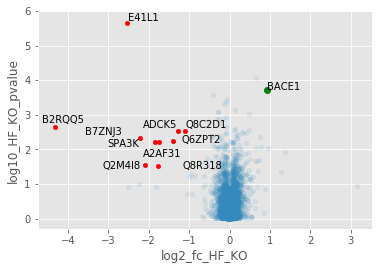

In [68]:
tag = 'HF_KO'

fig,ax=plt.subplots()
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
        hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],marker='o',c='g')

plt.text(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
         hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(' ')[0].replace('_MOUSE','')) for i in select.index.values]

adjust_text(texts)
genes = df.loc[select.index.values]['Fasta headers']
genes

In [69]:
df.loc[hippo_df[hippo_df['HF_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
8317,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,51;50;40,4;4;1,4;4;1,Band 4.1-like protein 1,Epb41l1,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,3,51,...,NaN,8317,1380;2404;5592;10174;11223;12384;13663;15626;1...,False;False;True;False;False;True;False;False;...,1419;2480;2481;5812;5813;10540;11634;11635;128...,5070;5071;5072;8444;8445;8446;8447;8448;8449;8...,5648;5649;5650;9370;9371;9372;9373;9374;9375;9...,5649;9371;20512;36573;40115;44314;48998;56008;...,414;415;416;417;418;419;420;421;422;4100,63;264;282;389;580;699;734;739;767;854


871     tr|A2AF31|A2AF31_MOUSE Thymosin beta 15b2 OS=M...
1319    tr|B2RQQ5|B2RQQ5_MOUSE Microtubule-associated ...
1527    tr|B7ZNJ3|B7ZNJ3_MOUSE Caskin1 protein OS=Mus ...
3144    sp|P07759|SPA3K_MOUSE Serine protease inhibito...
4285    tr|Q2M4I8|Q2M4I8_MOUSE Ptpns1 OS=Mus musculus ...
5842    tr|Q6ZPT2|Q6ZPT2_MOUSE MKIAA1352 protein (Frag...
6021    sp|Q80V03-2|ADCK5_MOUSE Isoform 2 of Uncharact...
6501    tr|Q8C2D1|Q8C2D1_MOUSE Putative uncharacterize...
6896    tr|Q8R318|Q8R318_MOUSE 2310005E10Rik protein O...
8317    sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...
Name: Fasta headers, dtype: object

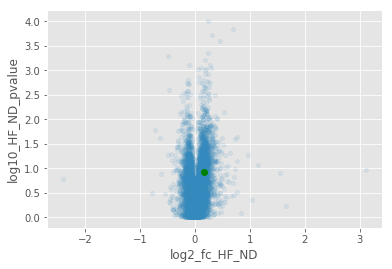

In [70]:
fig,ax=plt.subplots()
hippo_df.plot(kind='scatter',
             x='log2_fc_HF_ND',
             y='log10_HF_ND_pvalue', 
             ax=ax, alpha=0.1)

#hippo_df[(hippo_df['HF_ND_pvalue']<0.05) & 
#         ((hippo_df['log2_fc_HF_ND']<-1) | (hippo_df['log2_fc_HF_ND']>1))].plot(kind='scatter',
#             x='log2_fc_HF_ND',
#             y='log10_HF_ND_pvalue', 
#             ax=ax, c='r')

#select = hippo_df[(hippo_df['HF_ND_pvalue']<0.05) & 
#         ((hippo_df['log2_fc_HF_ND']<-1) | (hippo_df['log2_fc_HF_ND']>1))]

ax.plot(hippo_df.loc[3690]['log2_fc_HF_ND'],
        hippo_df.loc[3690]['log10_HF_ND_pvalue'],marker='o',c='g')

genes = df.loc[select.index.values]['Fasta headers']
genes#hippo_df.loc[3690]

In [71]:
hippo_cols = ['Reporter intensity corrected {} Hypo'.format(n) for n in range(0,10)]
hippo_df=df[hippo_cols]
hippo_df = hippo_df.replace(0, np.nan)
hippo_df.dropna(how='all', axis=0,inplace=True)
hippo_df.head(10)

,Reporter intensity corrected 0 Hypo,Reporter intensity corrected 1 Hypo,Reporter intensity corrected 2 Hypo,Reporter intensity corrected 3 Hypo,Reporter intensity corrected 4 Hypo,Reporter intensity corrected 5 Hypo,Reporter intensity corrected 6 Hypo,Reporter intensity corrected 7 Hypo,Reporter intensity corrected 8 Hypo,Reporter intensity corrected 9 Hypo
0,192810.0,198570.0,166900.0,161920.0,197730.0,190600.0,287050.0,180110.0,221870.0,110450.0
1,6704.4,7911.0,5781.0,7493.0,2626.0,6449.1,9535.0,4390.3,6926.0,3043.1
2,15451.0,17183.0,14503.0,14851.0,12532.0,16674.0,24024.0,14840.0,20258.0,9297.9
3,182720.0,174240.0,158310.0,170720.0,165740.0,190910.0,253360.0,160150.0,190820.0,93754.0
4,1188200.0,1164700.0,1118700.0,1319200.0,1165900.0,1278000.0,1599600.0,1005400.0,1325200.0,638670.0
5,5240.5,3712.3,3338.4,3796.0,2656.2,3611.7,4209.7,2365.1,3928.9,2055.3
6,263870.0,285480.0,238080.0,244420.0,256480.0,264180.0,408360.0,244490.0,315960.0,130150.0
8,181150.0,129290.0,125260.0,105760.0,142550.0,148570.0,234350.0,149980.0,139650.0,68941.0
9,15888.0,13829.0,14187.0,14268.0,6158.2,13453.0,21106.0,11437.0,19061.0,6066.0
10,1857.2,1689.6,1840.0,1628.1,1132.6,1737.4,2027.9,1307.3,1782.2,1243.1


In [72]:
hippo_df.columns = ['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3','null']
del hippo_df['null']
hippo_df.head(10)

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3
0,192810.0,198570.0,166900.0,161920.0,197730.0,190600.0,287050.0,180110.0,221870.0
1,6704.4,7911.0,5781.0,7493.0,2626.0,6449.1,9535.0,4390.3,6926.0
2,15451.0,17183.0,14503.0,14851.0,12532.0,16674.0,24024.0,14840.0,20258.0
3,182720.0,174240.0,158310.0,170720.0,165740.0,190910.0,253360.0,160150.0,190820.0
4,1188200.0,1164700.0,1118700.0,1319200.0,1165900.0,1278000.0,1599600.0,1005400.0,1325200.0
5,5240.5,3712.3,3338.4,3796.0,2656.2,3611.7,4209.7,2365.1,3928.9
6,263870.0,285480.0,238080.0,244420.0,256480.0,264180.0,408360.0,244490.0,315960.0
8,181150.0,129290.0,125260.0,105760.0,142550.0,148570.0,234350.0,149980.0,139650.0
9,15888.0,13829.0,14187.0,14268.0,6158.2,13453.0,21106.0,11437.0,19061.0
10,1857.2,1689.6,1840.0,1628.1,1132.6,1737.4,2027.9,1307.3,1782.2


In [73]:
col_sum = hippo_df.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
norm_facs

ND_1    1.024400
ND_2    1.029501
ND_3    1.146587
HF_1    1.114446
HF_2    0.976948
HF_3    1.019920
KO_1    0.721413
KO_2    1.189035
KO_3    0.950784
dtype: float64

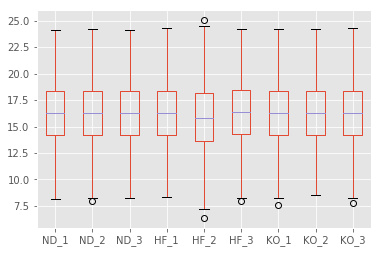

In [74]:
hippo_df = hippo_df.multiply(norm_facs,axis=1)
np.log2(hippo_df).plot(kind='box')

In [75]:
#from tqdm import tqdm_notebook
#from scipy.stats import f_oneway
#pvalue_list=[]
#for n in tqdm_notebook(hippo_df.index.values):
#    try:
#        onesample_results = f_oneway( np.log1p(hippo_df)[['ND_1','ND_2','ND_3']].iloc[n], 
#                                  np.log1p(hippo_df)[['KO_1','KO_2','KO_3']].iloc[n],
#                                  np.log1p(hippo_df)[['HF_1','HF_2','HF_3']].iloc[n])
#        pvalue_list.append(onesample_results.pvalue)
#        
#    except:
#        pvalue_list.append(np.nan)
        
            
        
    #print(onesample_results.statistic)
    #pvalues.append(onesample_results.pvalue)
#pvalues=pd.Series(pvalue_list,index=hippo_df.index.values)
#pvalues.plot(kind='hist')


[0.98109855 0.00841826]


No handles with labels found to put in legend.


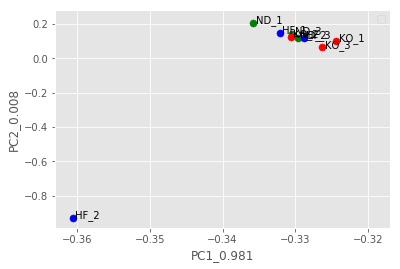

In [76]:
hippo_df=hippo_df.fillna(0)
#del hippo_df['HF_2']
make_pca(np.log1p(hippo_df))

In [77]:
onesample_results = ttest_ind(hippo_df[['ND_1','ND_2','ND_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['ND_KO_pvalue']=onesample_results.pvalue
hippo_df['ND_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['HF_KO_pvalue']=onesample_results.pvalue
hippo_df['HF_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['ND_1','ND_2','ND_3']].T)
#print(onesample_results)
hippo_df['HF_ND_pvalue']=onesample_results.pvalue
hippo_df['HF_ND_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]


hippo_df['log10_ND_KO_pvalue']=-np.log10(hippo_df['ND_KO_pvalue'])
hippo_df['log10_HF_KO_pvalue']=-np.log10(hippo_df['HF_KO_pvalue'])
hippo_df['log10_HF_ND_pvalue']=-np.log10(hippo_df['HF_ND_pvalue'])
hippo_df.head()

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3,ND_KO_pvalue,ND_KO_pvalue_corr,HF_KO_pvalue,HF_KO_pvalue_corr,HF_ND_pvalue,HF_ND_pvalue_corr,log10_ND_KO_pvalue,log10_HF_KO_pvalue,log10_HF_ND_pvalue
0,1.975145e+05,2.044281e+05,1.913654e+05,1.804511e+05,1.931719e+05,1.943968e+05,2.070817e+05,2.141572e+05,2.109505e+05,0.039171,1.0,0.012057,1.0,0.222438,1.0,1.407037,1.918769,0.652792
1,6.867985e+03,8.144385e+03,6.628421e+03,8.350545e+03,2.565465e+03,6.577568e+03,6.878675e+03,5.220222e+03,6.585132e+03,0.228918,1.0,0.835042,1.0,0.479520,1.0,0.640320,0.078292,0.319194
2,1.582800e+04,1.768992e+04,1.662896e+04,1.655064e+04,1.224311e+04,1.700615e+04,1.733123e+04,1.764529e+04,1.926099e+04,0.165582,1.0,0.159718,1.0,0.419122,1.0,0.780988,0.796647,0.377660
3,1.871783e+05,1.793803e+05,1.815162e+05,1.902582e+05,1.619193e+05,1.947130e+05,1.827772e+05,1.904240e+05,1.814287e+05,0.580780,1.0,0.820424,1.0,0.971890,1.0,0.235988,0.085962,0.012383
4,1.217192e+06,1.199060e+06,1.282687e+06,1.470177e+06,1.139023e+06,1.303458e+06,1.153973e+06,1.195456e+06,1.259979e+06,0.496606,1.0,0.371196,1.0,0.511226,1.0,0.303988,0.430397,0.291387


In [78]:
#for visualization later
hippo_df['mean_ND'] = hippo_df[['ND_1','ND_2','ND_3']].median(axis=1)
hippo_df['mean_HF'] = hippo_df[['HF_1','HF_2','HF_3']].median(axis=1)
hippo_df['mean_KO'] = hippo_df[['KO_1','KO_2','KO_3']].median(axis=1)

hippo_df['log2_fc_HF_ND'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_ND'])
hippo_df['log2_fc_ND_KO'] = np.log2(hippo_df['mean_ND']/hippo_df['mean_KO'])
hippo_df['log2_fc_HF_KO'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_KO'])


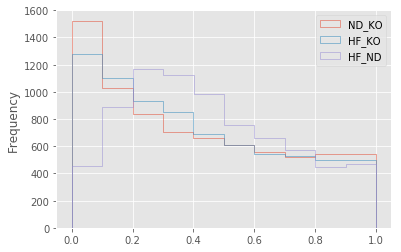

In [79]:
hippo_df['ND_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='ND_KO')
hippo_df['HF_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_KO')
hippo_df['HF_ND_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_ND')
plt.legend()
plt.show()

posx and posy should be finite values


499     tr|F7CW61|F7CW61_MOUSE All-trans-retinol 13,14...
923     tr|A2CEK9|A2CEK9_MOUSE Major urinary protein 1...
1319    tr|B2RQQ5|B2RQQ5_MOUSE Microtubule-associated ...
1595    tr|B9EKC3|B9EKC3_MOUSE Rho GTPase activating p...
3144    sp|P07759|SPA3K_MOUSE Serine protease inhibito...
4285    tr|Q2M4I8|Q2M4I8_MOUSE Ptpns1 OS=Mus musculus ...
4348    tr|Q3TBE9|Q3TBE9_MOUSE Deafness, autosomal dom...
4854    tr|Q3UG49|Q3UG49_MOUSE Putative uncharacterize...
6021    sp|Q80V03-2|ADCK5_MOUSE Isoform 2 of Uncharact...
6024    tr|Q80V84|Q80V84_MOUSE HtrA serine peptidase 2...
6896    tr|Q8R318|Q8R318_MOUSE 2310005E10Rik protein O...
6912    tr|Q8R3S9|Q8R3S9_MOUSE Ccdc93 protein (Fragmen...
8317    sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...
Name: Fasta headers, dtype: object

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


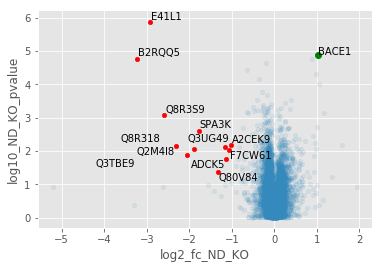

In [80]:
tag = 'ND_KO'

fig,ax=plt.subplots()
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
        hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],marker='o',c='g')

plt.text(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
         hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(' ')[0].replace('_MOUSE','')) for i in select.index.values]

adjust_text(texts)
genes = df.loc[select.index.values]['Fasta headers']
genes

In [81]:
df.loc[hippo_df[hippo_df['ND_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
8317,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,51;50;40,4;4;1,4;4;1,Band 4.1-like protein 1,Epb41l1,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,3,51,...,NaN,8317,1380;2404;5592;10174;11223;12384;13663;15626;1...,False;False;True;False;False;True;False;False;...,1419;2480;2481;5812;5813;10540;11634;11635;128...,5070;5071;5072;8444;8445;8446;8447;8448;8449;8...,5648;5649;5650;9370;9371;9372;9373;9374;9375;9...,5649;9371;20512;36573;40115;44314;48998;56008;...,414;415;416;417;418;419;420;421;422;4100,63;264;282;389;580;699;734;739;767;854


posx and posy should be finite values


923     tr|A2CEK9|A2CEK9_MOUSE Major urinary protein 1...
1134    sp|A6H6E2|MMRN2_MOUSE Multimerin-2 OS=Mus musc...
1319    tr|B2RQQ5|B2RQQ5_MOUSE Microtubule-associated ...
1595    tr|B9EKC3|B9EKC3_MOUSE Rho GTPase activating p...
3144    sp|P07759|SPA3K_MOUSE Serine protease inhibito...
3818    tr|Q5F239|Q5F239_MOUSE Putative uncharacterize...
4094    sp|Q00898|A1AT5_MOUSE Alpha-1-antitrypsin 1-5 ...
4285    tr|Q2M4I8|Q2M4I8_MOUSE Ptpns1 OS=Mus musculus ...
4348    tr|Q3TBE9|Q3TBE9_MOUSE Deafness, autosomal dom...
6021    sp|Q80V03-2|ADCK5_MOUSE Isoform 2 of Uncharact...
6896    tr|Q8R318|Q8R318_MOUSE 2310005E10Rik protein O...
6912    tr|Q8R3S9|Q8R3S9_MOUSE Ccdc93 protein (Fragmen...
7134    sp|Q91X52|DCXR_MOUSE L-xylulose reductase OS=M...
7152    tr|Q91XW9|Q91XW9_MOUSE MCG133388, isoform CRA_...
7904    sp|Q9DCA5|BRX1_MOUSE Ribosome biogenesis prote...
8317    sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...
Name: Fasta headers, dtype: object

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


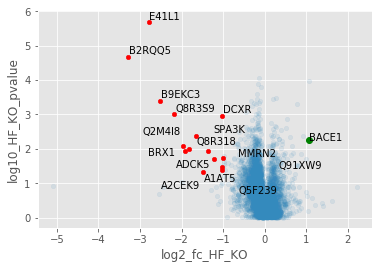

In [82]:
tag = 'HF_KO'

fig,ax=plt.subplots()
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
        hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],marker='o',c='g')

plt.text(hippo_df.loc[3690]['log2_fc_{}'.format(tag)],
         hippo_df.loc[3690]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(' ')[0].replace('_MOUSE','')) for i in select.index.values]

adjust_text(texts)
genes = df.loc[select.index.values]['Fasta headers']
genes

In [83]:
df.loc[hippo_df[hippo_df['HF_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
8317,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,Q9Z2H5;Q9Z2H5-2;Q9Z2H5-3,51;50;40,4;4;1,4;4;1,Band 4.1-like protein 1,Epb41l1,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,3,51,...,NaN,8317,1380;2404;5592;10174;11223;12384;13663;15626;1...,False;False;True;False;False;True;False;False;...,1419;2480;2481;5812;5813;10540;11634;11635;128...,5070;5071;5072;8444;8445;8446;8447;8448;8449;8...,5648;5649;5650;9370;9371;9372;9373;9374;9375;9...,5649;9371;20512;36573;40115;44314;48998;56008;...,414;415;416;417;418;419;420;421;422;4100,63;264;282;389;580;699;734;739;767;854


743     tr|E9QAE3|E9QAE3_MOUSE B-TFIID TATA-box-bindin...
7904    sp|Q9DCA5|BRX1_MOUSE Ribosome biogenesis prote...
Name: Fasta headers, dtype: object

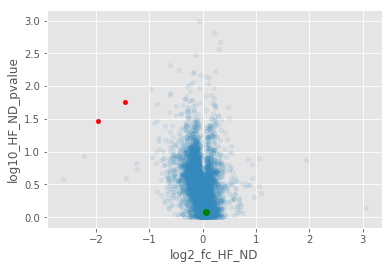

In [84]:
fig,ax=plt.subplots()
hippo_df.plot(kind='scatter',
             x='log2_fc_HF_ND',
             y='log10_HF_ND_pvalue', 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['HF_ND_pvalue']<0.05) & 
         ((hippo_df['log2_fc_HF_ND']<-1) | (hippo_df['log2_fc_HF_ND']>1))].plot(kind='scatter',
             x='log2_fc_HF_ND',
             y='log10_HF_ND_pvalue', 
             ax=ax, c='r')

select = hippo_df[(hippo_df['HF_ND_pvalue']<0.05) & 
         ((hippo_df['log2_fc_HF_ND']<-1) | (hippo_df['log2_fc_HF_ND']>1))]

ax.plot(hippo_df.loc[3690]['log2_fc_HF_ND'],
        hippo_df.loc[3690]['log10_HF_ND_pvalue'],marker='o',c='g')

genes = df.loc[select.index.values]['Fasta headers']
genes#hippo_df.loc[3690]

In [85]:
df.loc[hippo_df[hippo_df['HF_ND_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
